In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa

from utils import io
from utils import feature_engineering as fe

In [3]:
gt_folder = "../data/gt_annotations"
episode_names = ['Muppets-02-01-01', 'Muppets-02-04-04', 'Muppets-03-04-03']

In [4]:
gt_df = io.get_gt_df(episode_names, gt_folder)

# Feature Engineering

Idea: use straight lines for the detection of Balcony Gentlemens, since Balcony has a very characteristical straight lines. Can we use Hough Transform in Sim1? 

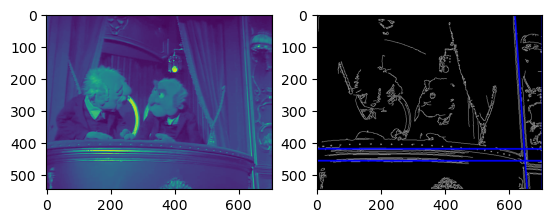

In [5]:
import math
import cv2 as cv
img_path = '../data/frames/frame_09404.jpg' 
src = cv.imread(img_path, cv.IMREAD_GRAYSCALE)    
dst = cv.Canny(src, 50, 200, None, 3)
    
cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

lines = cv.HoughLinesWithAccumulator(dst, 1, np.pi / 180, 200, None, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv.line(cdst, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
        if i == 3:
            break

plt.subplot(1,2,1)
plt.imshow(src)
plt.subplot(1,2,2)
plt.imshow(cdst)

Another idea: try to detect green blobs by highlighting the "Kermit" colors with Gaussian filter. Use skimgage Determinant of Hessian blob detector. Take 3 largest blob radien as features.

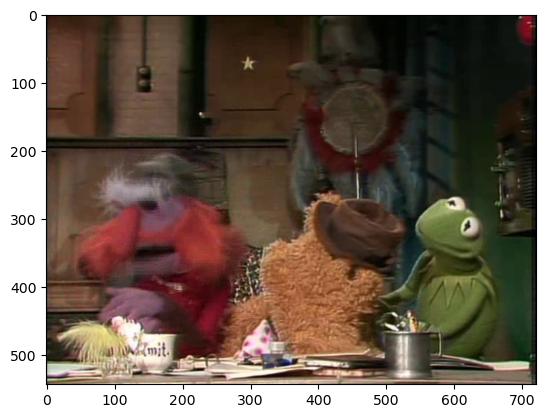

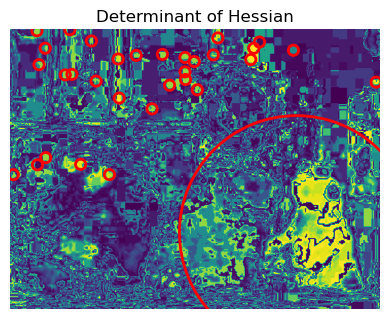

In [6]:
radius_col = 2
n_max = 3
debug = True

img_path = '../data/frames/frame_10934.jpg'
image = cv2.imread(img_path)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_rbg = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
if debug:
    plt.imshow(image_rbg)

sigma = 7
green_yellow = np.uint8([[[255*0.85, 255, 0]]])
hsv_green_yellow = cv2.cvtColor(green_yellow, cv2.COLOR_RGB2HSV)
mu = hsv_green_yellow[0, 0, 0]

blob_list = fe.detect_blob(image_hsv, sigma, mu, debug=debug)

Another idea we had is to detect Kermit's eyes by highlighting the yellowish-grey colors with high values. Sometimes it works, but in most cases it fails. We want to try to improve it by limiting number of hues in the images by retrieving dominant hues with clustering and replacing the original image hues by the dominant hues based on their cluster assignment.

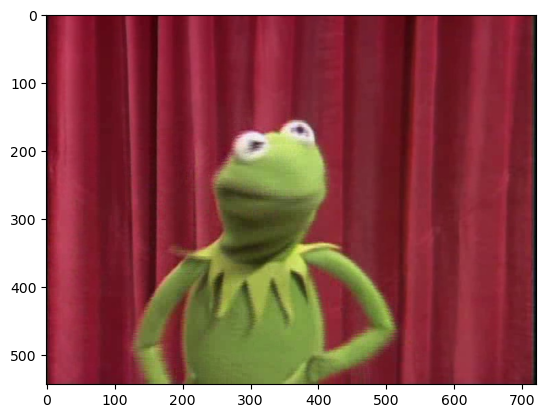

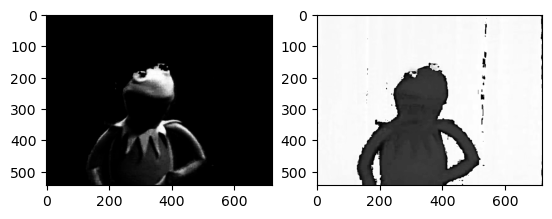

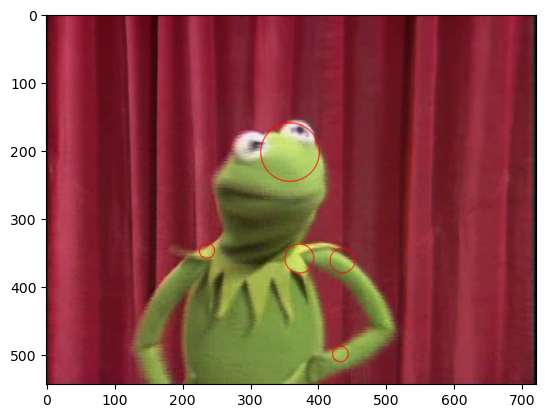

In [15]:
white_params = {
    'mu_v': 225, 
    'sigma_v': 35, 
    'mu_h': 40, 
    'sigma_h': 35
}
img_path = '../data/frames/frame_31720.jpg'
image = cv2.imread(img_path)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_rbg = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
if debug:
    plt.imshow(image_rbg)
    plt.show()

keypoints = fe.detect_blob_cv(image_gray, image, image_hsv, debug=debug, **white_params)

Here we try to get the dominant hues by clustering and replacing the original hues by the dominant hues based on their cluster assignments. Here we plot only the hue channel, but it can still be used in combination with original saturation and value.

[[0.608547794117647, 171], [0.15377093545751633, 9], [0.10867289624183006, 2], [0.10001021241830066, 39], [0.028998161764705883, 106]]


c:\Users\Alina\anaconda3\envs\SimilarityModeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1966: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


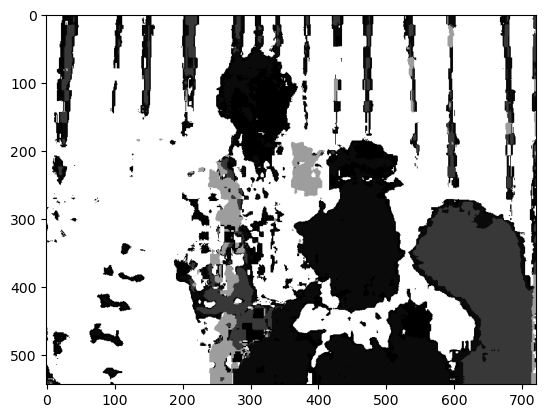

In [8]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.image as img
from scipy.cluster.vq import whiten

img_path = '../data/frames/frame_37154.jpg'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
 
hue = image[:, :, 0].flatten()
hue_std = hue.std()
scaled_hue = np.expand_dims(whiten(hue), -1)
 
 
n_clusters = 5
batch_size = 32
km = MiniBatchKMeans(n_clusters = n_clusters, batch_size=batch_size, n_init='auto').fit(scaled_hue)
cluster_centers = km.cluster_centers_


dominant_hues = []
for cluster_center in cluster_centers:
    hue_scaled = cluster_center[0]
 
    dominant_hues.append(
        hue_scaled * hue_std,
    )

hues = np.asarray(dominant_hues, dtype='uint8')

percentage = np.asarray(np.unique(km.labels_, return_counts = True)[1], dtype='float32')
percentage = percentage/(image.shape[0]*image.shape[1])

dom = [[percentage[ix], hues[ix]] for ix in range(km.n_clusters)]
dominance = sorted(dom, key=lambda x:x[0], reverse=True)
print(dominance)

image_cp = image.copy()

labels_mask = km.labels_.reshape(image.shape[0], image.shape[1])
for label in range(km.n_clusters):
    image_cp[labels_mask == label, 0] = hues[label]

img = image_cp.reshape(image.shape[0], -1, 3)
img = img[:, :, 0]

plt.imshow(img, cmap='grey')

We also tried to detect the edges with OpenCV, but we did not figure out how to use it as a feature yet.

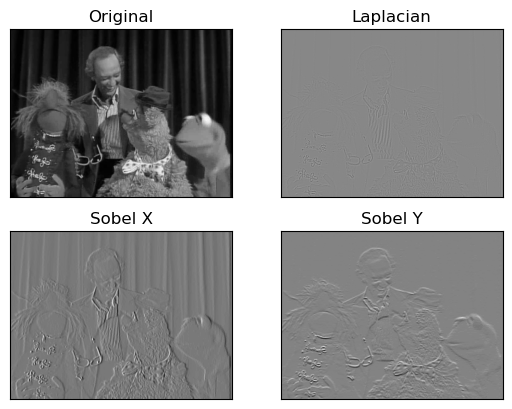

In [9]:
img_path = '../data/frames/frame_37154.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

We also try to compute basic audio features: RMS, ZCR and MFCC.

This code cannot be run since it needs the original videos. Thus it is commented out.

In [10]:
# ep_dfs = []
# for ep in episode_names:
#     rec, sr = librosa.load(video_paths[ep], sr=None)

#     frame_size_ms = 400
#     hop_length = int(1/25 * sr)
#     frame_length = int(frame_size_ms / 1000 * sr)
    
#     desired_len = len(gt_df[gt_df.episode==ep])
#     zcr = librosa.feature.zero_crossing_rate(y=rec, frame_length=frame_length, hop_length=hop_length)
#     zcr = np.pad(zcr, pad_width=((0, 0), (0, desired_len - zcr.shape[1]))).flatten()

#     rms = librosa.feature.rms(y=rec, frame_length=frame_length, hop_length=hop_length)
#     rms = np.pad(rms, pad_width=((0, 0), (0, desired_len - rms.shape[1]))).flatten()

#     mfcc = librosa.feature.mfcc(y=rec, sr=sr, n_fft=frame_length, hop_length=hop_length)
#     mfcc = np.pad(mfcc, pad_width=((0, 0), (0, desired_len - mfcc.shape[1])))

#     ep_df = pd.DataFrame()

#     ep_df['zcr'] = zcr
#     ep_df['rms'] = rms
    
#     for i in range(mfcc.shape[0]):
#         ep_df[f'mfcc_{i}'] = mfcc[i]
    
#     ep_df['episode'] = ep
#     ep_dfs.append(ep_df)

# feat_df = pd.concat(ep_dfs)

# Training & Evaluation

### Train-Test Split Thoughts
We decided to use nested CV for hyperparameter optimization (inner loop) and best models comparison (outer loop). By doing the nested CV we also don't have as much of a problem with e.g. the Swedish Chef being only in a small amount of scenes (which could lead to the chef being only represented in the test fold if we just do holdout for the test data). 

We are not completly sure how to split the episodes into multiple parts. Ofcourse we would try to create roughly equally-sized parts, while making sure that the cuts are not in the middle of a scene. Would it be ok to just split each episode in ~2-4 parts, so that we can create train-valid-splits with a ratio of e.g. 2/3-1/6-1/6?. This way we would mostly have data from each episode in the training set, which should improve the generalizability of the classifiers.

### First try in training and evaluation
For now, we have tried to classify using audio features and hue percentages (together and separately) with a DecisionTree. We can see that the results for Kermit classification are much better. Audio features are much more useful. The classification for gentlemen is still pretty bad. We hope to improve it by integrating the blob & line features.

Here we used full episodes for training and evaluation. We trained on 2 episodes (train_fold) and tested on 1 episode (test_fold). The result very much depends on which fold is being tested.

We did not do any hyperparameter optimisation yet, so the result will hopefully improve after we find optimal parameters.

In [11]:
kermit_eval_df = pd.read_csv("../data/eval/DT_Kermit.csv")
kermit_eval_df

,Unnamed: 0,model,config,precision,recall,f1,support,target,type,test_fold,train_fold,test_len
0,0,DT,zcr,0.115441,0.043494,0.063183,NaN,Kermit,testing,Muppets-02-01-01,"Muppets-02-04-04, Muppets-03-04-03",38681
1,0,DT,zcr,0.253968,0.016977,0.031826,NaN,Kermit,testing,Muppets-02-04-04,"Muppets-02-01-01, Muppets-03-04-03",38706
2,0,DT,zcr,0.363825,0.011284,0.021890,NaN,Kermit,testing,Muppets-03-04-03,"Muppets-02-01-01, Muppets-02-04-04",38498
3,0,DT,rms,0.144244,0.338227,0.202239,NaN,Kermit,testing,Muppets-02-01-01,"Muppets-02-04-04, Muppets-03-04-03",38681
4,0,DT,rms,0.311294,0.229024,0.263895,NaN,Kermit,testing,Muppets-02-04-04,"Muppets-02-01-01, Muppets-03-04-03",38706
5,0,DT,rms,0.388451,0.168300,0.234850,NaN,Kermit,testing,Muppets-03-04-03,"Muppets-02-01-01, Muppets-02-04-04",38498
6,0,DT,mfcc,0.192399,0.508167,0.279119,NaN,Kermit,testing,Muppets-02-01-01,"Muppets-02-04-04, Muppets-03-04-03",38681
7,0,DT,mfcc,0.434747,0.343944,0.384051,NaN,Kermit,testing,Muppets-02-04-04,"Muppets-02-01-01, Muppets-03-04-03",38706
8,0,DT,mfcc,0.435216,0.270312,0.333492,NaN,Kermit,testing,Muppets-03-04-03,"Muppets-02-01-01, Muppets-02-04-04",38498
9,0,DT,"hue, percentage",0.275822,0.484676,0.351571,NaN,Kermit,testing,Muppets-02-01-01,"Muppets-02-04-04, Muppets-03-04-03",38681


In [12]:
gents_eval_df = pd.read_csv("../data/eval/DT_Gents.csv")
gents_eval_df

,Unnamed: 0,model,config,precision,recall,f1,support,target,type,test_fold,train_fold,test_len
0,0,DecisionTree,"hue, percentage",0.163522,0.018388,0.033058,NaN,Audio_StatlerWaldorf,testing,Muppets-02-01-01,"Muppets-02-04-04, Muppets-03-04-03",38681
1,0,DecisionTree,"hue, percentage",0.034068,0.020631,0.025699,NaN,Audio_StatlerWaldorf,testing,Muppets-02-04-04,"Muppets-02-01-01, Muppets-03-04-03",38706
2,0,DecisionTree,"hue, percentage",0.324561,0.077244,0.124789,NaN,Audio_StatlerWaldorf,testing,Muppets-03-04-03,"Muppets-02-01-01, Muppets-02-04-04",38498
3,0,DecisionTree,"rms, zcr, mfcc",0.090000,0.050919,0.065041,NaN,Audio_StatlerWaldorf,testing,Muppets-02-01-01,"Muppets-02-04-04, Muppets-03-04-03",38681
4,0,DecisionTree,"rms, zcr, mfcc",0.053038,0.066748,0.059108,NaN,Audio_StatlerWaldorf,testing,Muppets-02-04-04,"Muppets-02-01-01, Muppets-03-04-03",38706
5,0,DecisionTree,"rms, zcr, mfcc",0.032891,0.217119,0.057127,NaN,Audio_StatlerWaldorf,testing,Muppets-03-04-03,"Muppets-02-01-01, Muppets-02-04-04",38498
6,0,DecisionTree,"zcr, mfcc, rms, percentage, hue",0.185567,0.025460,0.044776,NaN,Audio_StatlerWaldorf,testing,Muppets-02-01-01,"Muppets-02-04-04, Muppets-03-04-03",38681
7,0,DecisionTree,"zcr, mfcc, rms, percentage, hue",0.144251,0.251214,0.183267,NaN,Audio_StatlerWaldorf,testing,Muppets-02-04-04,"Muppets-02-01-01, Muppets-03-04-03",38706
8,0,DecisionTree,"zcr, mfcc, rms, percentage, hue",0.457447,0.448852,0.453109,NaN,Audio_StatlerWaldorf,testing,Muppets-03-04-03,"Muppets-02-01-01, Muppets-02-04-04",38498
9,0,DecisionTree,"hue, percentage",0.185484,0.025570,0.044944,NaN,StatlerWaldorf,testing,Muppets-02-01-01,"Muppets-02-04-04, Muppets-03-04-03",38681
